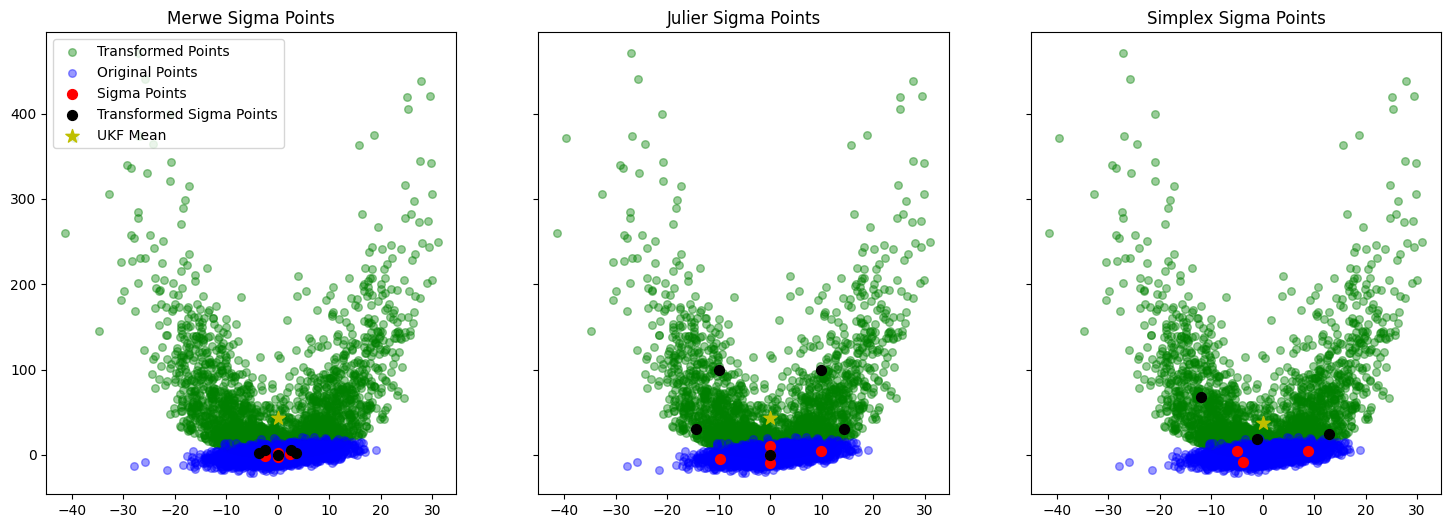

In [44]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints, JulierSigmaPoints, SimplexSigmaPoints
import scipy.stats as stats
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt


def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])


# initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
n = 2
points = MerweScaledSigmaPoints(n=n, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

points_julier = JulierSigmaPoints(n=n, kappa=1)
sigmas_julier = points_julier.sigma_points(mean, p)

points_simplex = SimplexSigmaPoints(n=2, alpha=1)
sigmas_simplex = points_simplex.sigma_points(np.array(mean), p)


### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

# pass other sigma points through function
sigmas_f_julier = np.empty((5, 2))
for i in range(5):
    sigmas_f_julier[i] = f_nonlinear_xy(sigmas_julier[i, 0], sigmas_julier[i ,1])

sigmas_f_simplex = np.empty((3, 2))
for i in range(3):
    sigmas_f_simplex[i] = f_nonlinear_xy(sigmas_simplex[i, 0], sigmas_simplex[i ,1])


### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)
ukf_mean_julier, ukf_cov_julier = unscented_transform(sigmas_f_julier, points_julier.Wm, points_julier.Wc)
ukf_mean_simplex, ukf_cov_simplex = unscented_transform(sigmas_f_simplex, points_simplex.Wm, points_simplex.Wc)



# generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=3000).T

# pass through nonlinear function
xs_nl, ys_nl = f_nonlinear_xy(xs, ys)



fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)


alpha = .4

ax[0].scatter(xs_nl, ys_nl, c='g', s=30, alpha=alpha, label='Transformed Points')
ax[0].scatter(xs, ys, c='b', s=30, alpha=alpha, label='Original Points')

ax[0].scatter(sigmas[:,0], sigmas[:,1], c='r', s=50, label='Sigma Points')
ax[0].scatter(sigmas_f[:,0], sigmas_f[:,1], c='k', s=50, label='Transformed Sigma Points')

ax[0].scatter(ukf_mean[0], ukf_mean[1], c='y', s=100, label='UKF Mean', marker='*')

ax[1].scatter(xs_nl, ys_nl, c='g', s=30, alpha=alpha)
ax[1].scatter(xs, ys, c='b', s=30, alpha=alpha)

ax[1].scatter(sigmas_julier[:,0], sigmas_julier[:,1], c='r', s=50)
ax[1].scatter(sigmas_f_julier[:,0], sigmas_f_julier[:,1], c='k', s=50)

ax[1].scatter(ukf_mean_julier[0], ukf_mean_julier[1], c='y', s=100, marker='*')

ax[2].scatter(xs_nl, ys_nl, c='g', s=30, alpha=alpha)
ax[2].scatter(xs, ys, c='b', s=30, alpha=alpha)

ax[2].scatter(sigmas_simplex[:,0], sigmas_simplex[:,1], c='r', s=50)
ax[2].scatter(sigmas_f_simplex[:,0], sigmas_f_simplex[:,1], c='k', s=50)

ax[2].scatter(ukf_mean_simplex[0], ukf_mean_simplex[1], c='y', s=100, marker='*')


ax[0].set_title('Merwe Sigma Points')
ax[1].set_title('Julier Sigma Points') 
ax[2].set_title('Simplex Sigma Points')

ax[0].legend(loc=2)

#

plt.show()